# Wine-finder

## 1. Libraries

In [203]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

## 2. Reading data

The data read has been scraped from systembolaget by a script that:
1. Navigated prompts on cookies and age restriction
2. Fetched unique urls per wine product
3. Extracted product number, category, subcategory, name, country, region, volume, percentage alc, price, taste metrics from each product page

In [204]:
# reading data
df = pd.read_csv("10k_wines_v4")
df.drop(columns="Unnamed: 0", inplace=True)
df.rename(columns= {"SEK_per_ml":"ml_per_SEK"}, inplace=True) # wrong name

## 3. Data inspection

In [205]:
# example obs 
df.head()

,product_number,category,sub_category,name,region,volume,pct_alc,price_SEK,fyllighet,strävhet,fruktsyra,sötma,country,volume_ml,apk,ml_per_SEK
0,53886,Vin,Vinlåda,"""All about Celler Bartolome"" låda","Spanien, Katalonien, Priorat",3 fl à 750 ml 2250 ml,14.5,1203.0,NaN,NaN,NaN,NaN,Spanien,2250,0.271197,1.870324
1,53888,Vin,Vermouth,"""All about Vermouth Lacuesta"" låda",Spanien,3 fl à 750 ml 2250 ml,15.0,1005.0,NaN,NaN,NaN,NaN,Spanien,2250,0.335821,2.238806
2,92456,Vin,Rött vin,'a Rina,"Italien, Sicilien, Etna",Flaska 750 ml,14.0,219.0,7.0,9.0,10.0,NaN,Italien,750,0.479452,3.424658
3,55190,Vin,Rött vin,.Parusso,"Italien, Piemonte, Barolo",Flaska 750 ml,15.0,841.0,NaN,NaN,NaN,NaN,Italien,750,0.133769,0.891795
4,58660,Vin,Rött vin,05035,"Italien, Umbrien",Flaska 750 ml,13.5,221.0,NaN,NaN,NaN,NaN,Italien,750,0.458145,3.393665


In [206]:
# data set includes ~10 k products
len(df)

9978

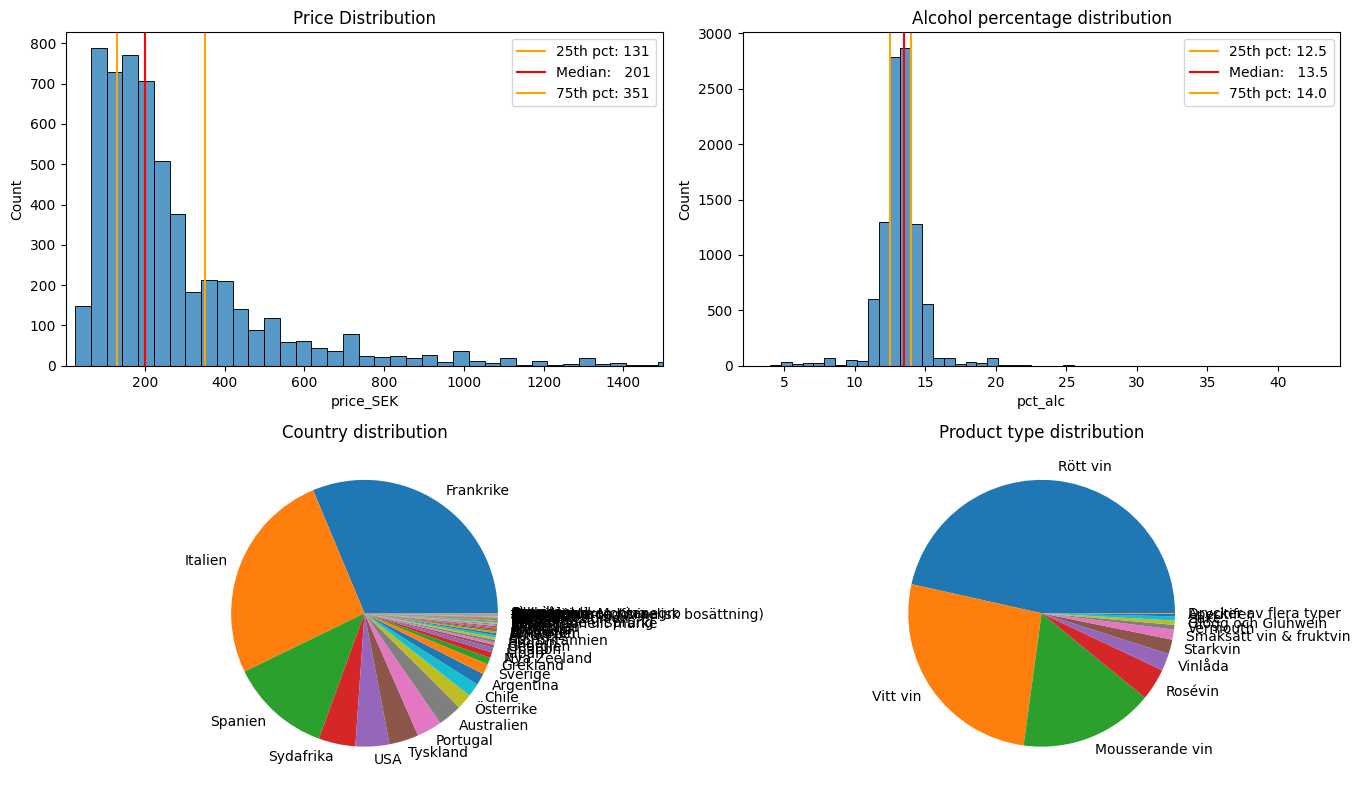

In [207]:
# selected data vis

fig, ax = plt.subplots(2,2, figsize = (14,8))

# price distribution
wine_under_2kSEK = df.loc[df.price_SEK < 2000]
sns.histplot(data = wine_under_2kSEK, x="price_SEK", bins=50, ax=ax[0][0])

ax[0][0].set_xlim(1,1500)
ax[0][0].axvline(x=df.price_SEK.quantile(0.25), color="orange", label="25th pct: "+str(round(df.price_SEK.quantile(0.25))))
ax[0][0].axvline(x=df.price_SEK.median(), color="red", label="Median:   "+str(round(df.price_SEK.median())))
ax[0][0].axvline(x=df.price_SEK.quantile(0.75), color="orange", label="75th pct: "+str(round(df.price_SEK.quantile(0.75))))
ax[0][0].legend()
ax[0][0].set_title('Price Distribution')

# alcohol pct distrivution
sns.histplot(data = df, x="pct_alc", bins=50, ax=ax[0][1])
ax[0][1].axvline(x=df.pct_alc.quantile(0.25), color="orange", label="25th pct: "+str(round(df.pct_alc.quantile(0.25),2)))
ax[0][1].axvline(x=df.pct_alc.median(), color="red", label="Median:   "+str(round(df.pct_alc.median(),2)))
ax[0][1].axvline(x=df.pct_alc.quantile(0.75), color="orange", label="75th pct: "+str(round(df.pct_alc.quantile(0.75),2)))
ax[0][1].legend()
ax[0][1].set_title('Alcohol percentage distribution')

# countries
country_count = df.country.value_counts()
ax[1][0].pie(x=country_count, labels=country_count.index)
ax[1][0].set_title('Country distribution')

# sub_categories
sub_cat_count = df.sub_category.value_counts()
ax[1][1].pie(x=sub_cat_count, labels=sub_cat_count.index)
ax[1][1].set_title('Product type distribution')

plt.tight_layout()
plt.show()

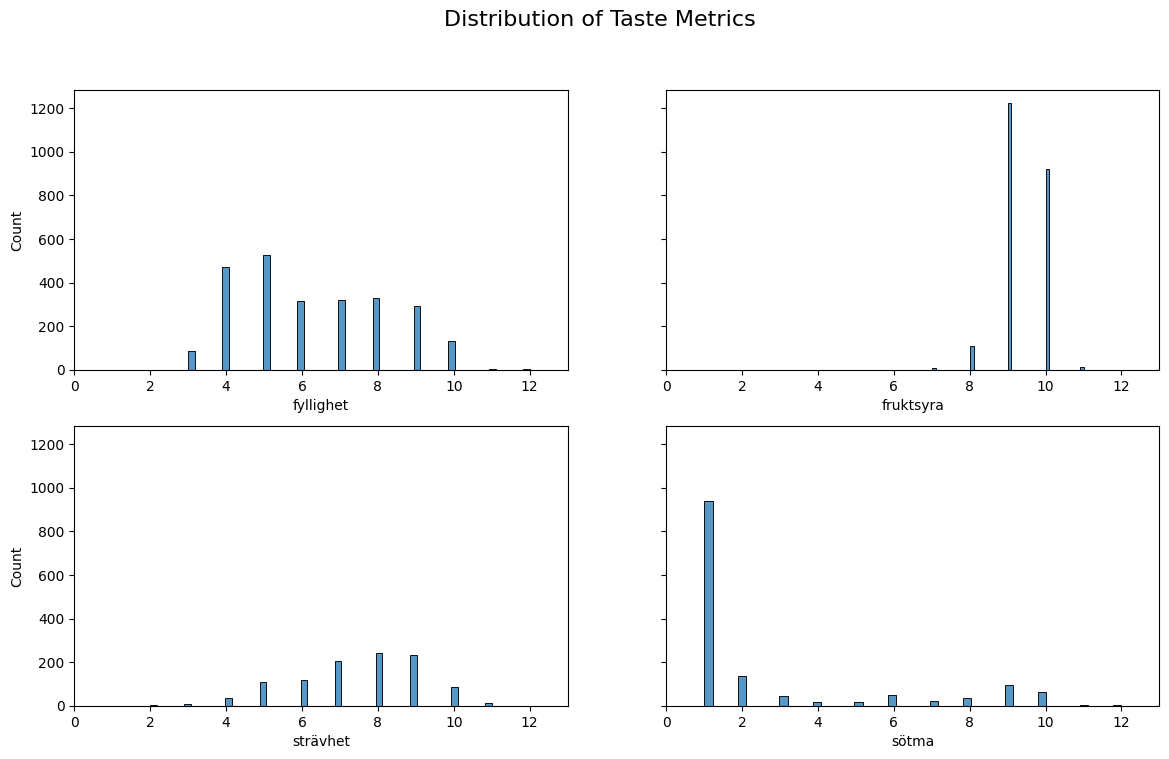

In [208]:
# Distribution of taste metrics
fig, ax = plt.subplots(2,2, figsize = (14,8), sharey=True)

x_axis_limits = (0, 13)

sns.histplot(data = df, x="fyllighet", bins=50, ax=ax[0][0]).set_xlim(x_axis_limits)
sns.histplot(data = df, x="strävhet", bins=50, ax=ax[1][0]).set_xlim(x_axis_limits)
sns.histplot(data = df, x="fruktsyra", bins=50, ax=ax[0][1]).set_xlim(x_axis_limits)
sns.histplot(data = df, x="sötma", bins=50, ax=ax[1][1]).set_xlim(x_axis_limits)

fig.suptitle('Distribution of Taste Metrics', fontsize=16)

plt.show()

## 4. Similar wine finder
Creating a function that finds similar wines

In [209]:
# Scaling numerical columns
columns_to_scale = ["fyllighet", "strävhet", "fruktsyra", "sötma", "volume_ml", "price_SEK"]

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df[columns_to_scale])
minmax_data = scaler.transform(df[columns_to_scale])

df_minmax = pd.DataFrame(minmax_data, columns=columns_to_scale)

# Onehotencoding categorical columns
columns_to_onehot = ["sub_category", "country"]

onehot = OneHotEncoder(drop = "if_binary")
onehot.fit(df[columns_to_onehot])
onehot_data = onehot.transform(df[columns_to_onehot])

feature_names_out = onehot.get_feature_names_out(columns_to_onehot)
df_onehot = pd.DataFrame(onehot_data.toarray(), columns=feature_names_out)

# Merging data into one df
scaled_df = pd.concat([df[["product_number"]],
                       df_minmax,
                       df_onehot],
                      axis=1).set_index("product_number")

In [210]:
# Creating a function that finds similar wines by calculating (manhattan) distance between observations

def find_similar_wine(prodnumb):
    columns = scaled_df.loc[prodnumb].dropna().index
    
    target_wine = scaled_df.loc[prodnumb][columns]
    
    temp_df = scaled_df[columns].apply(lambda x: abs(x - target_wine), axis = 1)
    
    temp_df = temp_df.dropna(axis=0)

    temp_df['sum_diff'] = temp_df.sum(axis=1)

    similar_wines = temp_df.sort_values(by='sum_diff').head(4).index
    
    return df[df["product_number"].isin(list(similar_wines))]
    

## 5. Examples

Below are example outputs of the find_similar_wine function. As seen, the wines are similar in terms of taste, origin and price.

In [211]:
find_similar_wine(92456)

,product_number,category,sub_category,name,region,volume,pct_alc,price_SEK,fyllighet,strävhet,fruktsyra,sötma,country,volume_ml,apk,ml_per_SEK
2,92456,Vin,Rött vin,'a Rina,"Italien, Sicilien, Etna",Flaska 750 ml,14.0,219.0,7.0,9.0,10.0,NaN,Italien,750,0.479452,3.424658
443,90448,Vin,Rött vin,Amos,Italien,Flaska 750 ml,14.0,231.0,6.0,9.0,10.0,NaN,Italien,750,0.454545,3.246753
3817,94062,Vin,Rött vin,Costa Bassa,"Italien, Lombardiet, Valtellina, Valtellina Su...",Flaska 750 ml,13.5,201.0,8.0,9.0,10.0,NaN,Italien,750,0.503731,3.731343
4999,72399,Vin,Rött vin,Enzo Bartoli,"Italien, Piemonte, Barolo",Flaska 750 ml,13.5,211.0,8.0,9.0,10.0,NaN,Italien,750,0.479858,3.554502


In [212]:
find_similar_wine(73968)

,product_number,category,sub_category,name,region,volume,pct_alc,price_SEK,fyllighet,strävhet,fruktsyra,sötma,country,volume_ml,apk,ml_per_SEK
26,73968,Vin,Rött vin,19 Crimes,"Australien, South Eastern Australia",Flaska 750 ml,13.5,101.0,9.0,8.0,9.0,NaN,Australien,750,1.002475,7.425743
2289,6573,Vin,Rött vin,Caravan,"Australien, South Eastern Australia",Lättare glasflaska 750 ml,14.0,91.0,9.0,8.0,9.0,NaN,Australien,750,1.153846,8.241758
5707,20033,Vin,Rött vin,Gemtree,"Australien, South Australia, Fleurieu, McLaren...",Lättare glasflaska 750 ml,14.5,121.0,9.0,8.0,9.0,NaN,Australien,750,0.898760,6.198347
6383,6894,Vin,Rött vin,Hope,"Australien, South Eastern Australia",Lättare glasflaska 750 ml,14.5,97.0,9.0,8.0,9.0,NaN,Australien,750,1.121134,7.731959


In [213]:
find_similar_wine(2654)

,product_number,category,sub_category,name,region,volume,pct_alc,price_SEK,fyllighet,strävhet,fruktsyra,sötma,country,volume_ml,apk,ml_per_SEK
36,2654,Vin,Vitt vin,3 Generations of Peace,"Sydafrika, Western Cape, Coastal Region, Paarl",Lättare glasflaska 750 ml,13.0,121.0,4.0,NaN,10.0,1.0,Sydafrika,750,0.805785,6.198347
6907,2321,Vin,Vitt vin,KWV Cathedral Cellar,"Sydafrika, Western Cape, Coastal Region, Swart...",Lättare glasflaska 750 ml,13.5,141.0,4.0,NaN,10.0,1.0,Sydafrika,750,0.718085,5.319149
7036,20035,Vin,Vitt vin,Kleine Zalze,"Sydafrika, Western Cape",Lättare glasflaska 750 ml,13.0,111.0,5.0,NaN,10.0,1.0,Sydafrika,750,0.878378,6.756757
9052,6293,Vin,Vitt vin,Moonlight Manor,"Sydafrika, Western Cape",Lättare glasflaska 750 ml,12.5,96.0,4.0,NaN,10.0,1.0,Sydafrika,750,0.976562,7.812500
